<a href="https://colab.research.google.com/github/duneag2/intro-dl/blob/main/DLMATHon/uh/dlmathon1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! unzip -qq '/content/drive/MyDrive/2021-data-creator-camp-1120-1' -d '/content/drive/MyDrive'

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/kfood/

/content/drive/MyDrive/kfood


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [6]:
train_dir = '/content/drive/MyDrive/kfood/train'
val_dir = '/content/drive/MyDrive/kfood/val'


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, data_transforms['val'])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
model = models.resnet50(pretrained=True)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.9MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 1.0853
Epoch 2/10, Loss: 0.8060
Epoch 3/10, Loss: 0.7097
Epoch 4/10, Loss: 0.6772
Epoch 5/10, Loss: 0.6680
Epoch 6/10, Loss: 0.6175
Epoch 7/10, Loss: 0.6214
Epoch 8/10, Loss: 0.5908
Epoch 9/10, Loss: 0.5893
Epoch 10/10, Loss: 0.5617


In [10]:
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

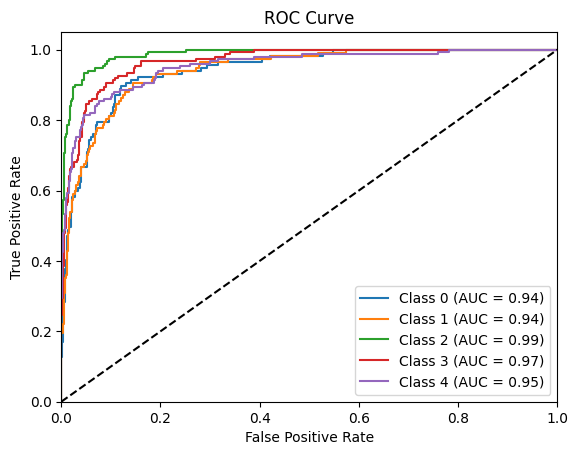

In [11]:
from sklearn.preprocessing import label_binarize

all_labels_bin = label_binarize(all_labels, classes=range(len(train_dataset.classes)))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(train_dataset.classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()